In [1]:
#use a hierchal bayesian model to put constraints on the age 
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [49]:
UOBS=-0.74
VOBS=-12.2
WOBS=-8.

In [56]:
#D

In [41]:
nsample=5e4
with pm.Model() as model:
    
    v10 = 41.899
    tau1 = 0.001
    beta = 0.307

    v10_v = 28.823
    tau_v = 0.715
    beta_v = 0.430

    v10_w = 23.381
    tau_w = 0.001
    beta_w = 0.445
    k = 74.
    

    age=pm.Uniform('age', lower=1.0, upper=13.)
    
    sigma_u = pm.Deterministic('sigma_u',  v10*((age+tau1)/(10.+tau1))**beta)
    uvel =pm.Normal('uvel', mu=0.0, sigma=sigma_u, observed=UOBS)

    sigma_v = pm.Deterministic('sigma_v', v10_v*((age+tau_v)/(10.+tau_v))**beta_v)
    
    voff = -1.*(sigma_v**2)/k
    vvel = pm.Normal('vvel', mu=voff,sigma=sigma_v, observed=VOBS)
    
    sigma_w = pm.Deterministic('sigma_w', v10_w*((age+tau_w)/(10.+tau_w))**beta_w)
    wvel = pm.Normal('wvel', mu=0., sigma=sigma_w, observed=WOBS)
                     
    trace = pm.sample(draws=int(nsample), cores=4, tune=int(nsample/20),
            discard_tuned_samples=True, step=pm.Metropolis(), return_inferencedata=False )
    

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [age]


Sampling 4 chains for 2_500 tune and 50_000 draw iterations (10_000 + 200_000 draws total) took 117 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [31]:
#h=pm.traceplot(trace)

In [42]:
pm.summary(trace).round(2)

/opt/anaconda3/envs/mcmcenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
age,12.97,0.03,12.91,13.00,0.0,0.0,46036.0,46003.0,37107.0,36079.0,1.0
sigma_u,45.38,0.03,45.32,45.41,0.0,0.0,46058.0,46048.0,37107.0,36079.0,1.0
sigma_v,32.02,0.03,31.96,32.05,0.0,0.0,46053.0,46040.0,37107.0,36079.0,1.0
sigma_w,26.25,0.03,26.20,26.28,0.0,0.0,46054.0,46039.0,37107.0,36079.0,1.0


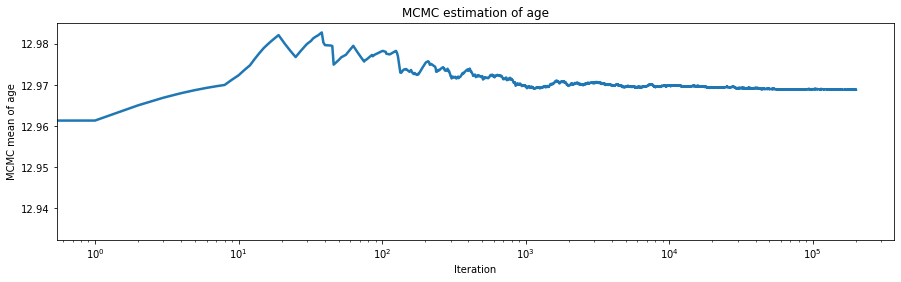

In [44]:
# plot the estimate for the mean of τ cumulating mean
tau = trace["age"]
mtau = [np.mean(tau[:i]) for i in np.arange(1, len(tau))]
plt.figure(figsize=(15, 4))
#plt.axhline(4.97, lw=2.5, color="gray")
plt.plot(mtau, lw=2.5)
plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel("MCMC mean of age")
plt.title("MCMC estimation of age");

In [58]:
#look!

In [45]:
import corner

In [46]:
trace.get_values('age')
sigma_v= (trace.sigma_u**2+ trace.sigma_v**2+ trace.sigma_w**2)**0.5

In [47]:
stats=trace.get_sampler_stats('accepted')
ages=trace.age[stats]
sigmas=sigma_v[stats]
samples= np.vstack([ages, trace.sigma_u[stats], trace.sigma_v[stats], trace.sigma_w[stats]])

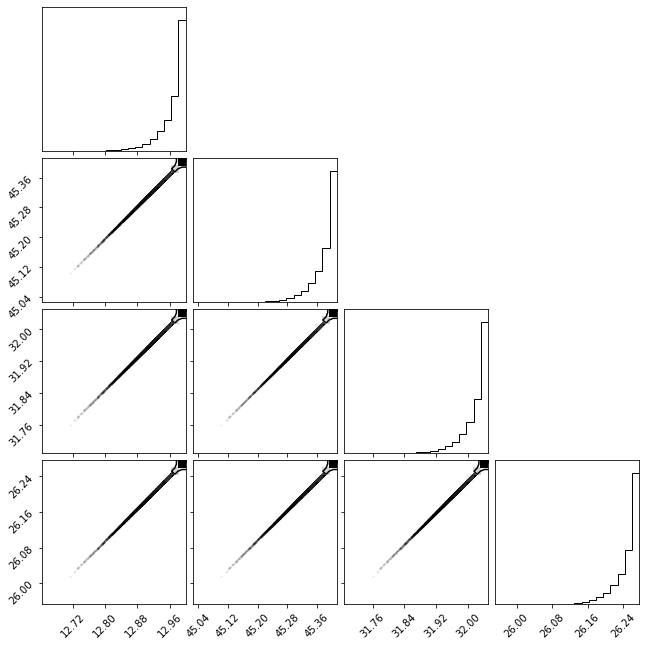

In [59]:
h=corner.corner(samples.T)

In [37]:
# pm.Deterministic?

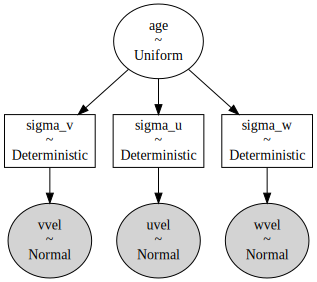

In [57]:
pm.model_to_graphviz(model)

In [ ]:
ghjkghj

In [47]:
#pm.Interpolated?
#start from the age distribution of gcs sample

In [50]:
import pandas as pd
gcs=pd.read_csv('/users/caganze/research/J1624/data//gcs_catalog.csv')

In [53]:
metal=(0.29, 0.07) #measured metallicity
#take everything within 3 sigma
bools=gcs['__Fe_H_'].between(metal[0]-3*metal[-1], metal[0]+3*metal[-1] )
gcs_ages=gcs.ageMLP[bools].values

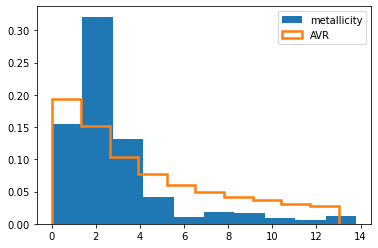

In [59]:
h=plt.hist(gcs_ages, density=True, label='metallicity')
h=plt.hist(trace['age'], density=True, histtype='step', lw=2.5, label='AVR')
plt.legend()

In [61]:
#get variable from the metallicity ages as new prior
from pymc3.distributions import Interpolated



In [72]:
GCSAGX=gcs_ages[~np.isnan(gcs_ages)]
smin, smax = np.min(GCSAGX), np.max(GCSAGX)
width = smax - smin
x = np.linspace(smin, smax, 100)
y = stats.gaussian_kde(GCSAGX)(x)

In [89]:
#plt.kde

In [71]:
#with pm.Model() as m:
#    age=

array([3.8, 1.2, 2.1, ..., 2.7, 2.1, 1.6])

In [75]:
nsample=5e4
with pm.Model() as model_metal:
    
    v10 = 41.899
    tau1 = 0.001
    beta = 0.307

    v10_v = 28.823
    tau_v = 0.715
    beta_v = 0.430

    v10_w = 23.381
    tau_w = 0.001
    beta_w = 0.445
    k = 74.
    
    
    #beta=pm.Uniform('beta', lower=0.001, upper=1.)
    #age=pm.Gamma('age', alpha=5., beta=beta)
    #age=pm.Uniform('age', lower=0.0, upper=13.)
    age=Interpolated('age', x, y)
    
    sigma_u = pm.Deterministic('sigma_u',  v10*((age+tau1)/(10.+tau1))**beta)
    uvel =pm.Normal('uvel', mu=0.0, sigma=sigma_u, observed=UOBS)

    sigma_v = pm.Deterministic('sigma_v', v10_v*((age+tau_v)/(10.+tau_v))**beta_v)
    
    voff = -1.*(sigma_v**2)/k
    vvel = pm.Normal('vvel', mu=voff,sigma=sigma_v, observed=VOBS)
    
    sigma_w = pm.Deterministic('sigma_w', v10_w*((age+tau_w)/(10.+tau_w))**beta_w)
    wvel = pm.Normal('wvel', mu=0., sigma=sigma_w, observed=WOBS)
    
    trace_metal = pm.sample(draws=int(nsample), cores=4, tune=int(nsample/20),
            discard_tuned_samples=True, step=pm.Metropolis(), return_inferencedata=False )
    

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [age]


Sampling 4 chains for 2_500 tune and 50_000 draw iterations (10_000 + 200_000 draws total) took 203 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [77]:
pm.summary(trace_metal).round(2)

/opt/anaconda3/envs/pymcenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
age,2.09,1.54,0.10,4.27,0.01,0.01,37459.0,36671.0,1.0
sigma_u,24.76,5.05,14.42,33.59,0.03,0.02,37459.0,36671.0,1.0
sigma_v,15.75,3.24,10.00,20.97,0.02,0.01,37459.0,36671.0,1.0
sigma_w,11.06,3.28,4.77,16.71,0.02,0.01,37459.0,36671.0,1.0


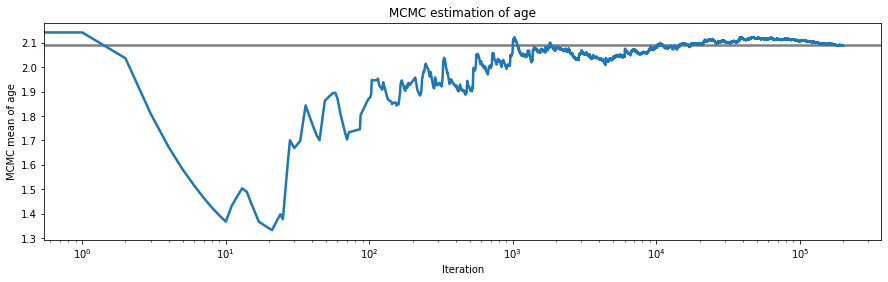

In [78]:
# plot the estimate for the mean of τ cumulating mean
tau = trace_metal["age"]
mtau = [np.mean(tau[:i]) for i in np.arange(1, len(tau))]
plt.figure(figsize=(15, 4))
plt.axhline(2.09, lw=2.5, color="gray")
plt.plot(mtau, lw=2.5)
plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel("MCMC mean of age")
plt.title("MCMC estimation of age");

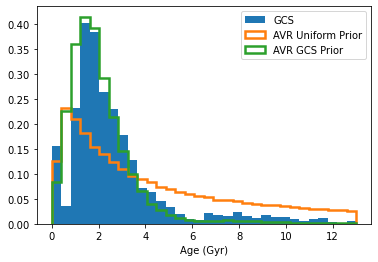

In [95]:
h=plt.hist(gcs_ages, density=True, label='GCS', bins=32, range=[0, 13])
h=plt.hist(trace['age'], density=True, histtype='step', lw=2.5,
           label='AVR Uniform Prior', bins=32, range=[0, 13])
h=plt.hist(trace_metal['age'], density=True, histtype='step', lw=2.5, 
           label='AVR GCS Prior', bins=32, range=[0, 13])
plt.xlabel('Age (Gyr)')
plt.legend()

In [94]:
#pm.plot_posterior(trace['age'])
#pm.plot_posterior(trace_metal['age'])

In [98]:
#add my own likelihood (chisquare)
nsample=5e4
def logp(u, v, w):
    return -(u+0.74480971)**2-(v+12.224687)**2-(w+8.2923634)**2
with pm.Model() as model_custom:
    
    v10 = 41.899
    tau1 = 0.001
    beta = 0.307

    v10_v = 28.823
    tau_v = 0.715
    beta_v = 0.430

    v10_w = 23.381
    tau_w = 0.001
    beta_w = 0.445
    k = 74.
    
    
    #beta=pm.Uniform('beta', lower=0.001, upper=1.)
    #age=pm.Gamma('age', alpha=5., beta=beta)
    #age=pm.Uniform('age', lower=0.0, upper=13.)
    age=Interpolated('age', x, y)
    
    sigma_u = pm.Deterministic('sigma_u',  v10*((age+tau1)/(10.+tau1))**beta)
    uvel =pm.Normal('uvel', mu=0.0, sigma=sigma_u)

    sigma_v = pm.Deterministic('sigma_v', v10_v*((age+tau_v)/(10.+tau_v))**beta_v)
    
    voff = -1.*(sigma_v**2)/k
    vvel = pm.Normal('vvel', mu=voff,sigma=sigma_v)
    
    sigma_w = pm.Deterministic('sigma_w', v10_w*((age+tau_w)/(10.+tau_w))**beta_w)
    wvel = pm.Normal('wvel', mu=0., sigma=sigma_w)
    
    like = pm.Potential('likelihood', logp(uvel, vvel, wvel))
    
    trace_custom = pm.sample(draws=int(nsample), cores=4, tune=int(nsample/20),
            discard_tuned_samples=True, step=pm.Metropolis(), return_inferencedata=False )
    


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [wvel]
>Metropolis: [vvel]
>Metropolis: [uvel]
>Metropolis: [age]


Sampling 4 chains for 2_500 tune and 50_000 draw iterations (10_000 + 200_000 draws total) took 201 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [100]:
pm.summary(trace_custom).round(2)

/opt/anaconda3/envs/pymcenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
uvel,-0.75,0.70,-2.05,0.60,0.00,0.00,45286.0,50669.0,1.0
vvel,-12.20,0.71,-13.55,-10.89,0.00,0.00,45118.0,47323.0,1.0
wvel,-8.25,0.71,-9.57,-6.91,0.00,0.00,44672.0,47914.0,1.0
age,2.08,1.54,0.14,4.31,0.01,0.01,37556.0,35778.0,1.0
sigma_u,24.73,5.06,14.57,33.78,0.03,0.02,37556.0,35778.0,1.0
sigma_v,15.74,3.24,10.07,21.08,0.02,0.01,37556.0,35778.0,1.0
sigma_w,11.03,3.29,4.59,16.56,0.02,0.01,37556.0,35778.0,1.0


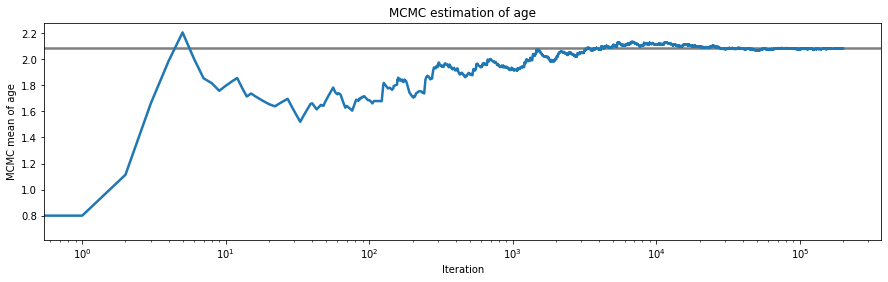

In [99]:
tau = trace_custom["age"]
mtau = [np.mean(tau[:i]) for i in np.arange(1, len(tau))]
plt.figure(figsize=(15, 4))
plt.axhline(2.09, lw=2.5, color="gray")
plt.plot(mtau, lw=2.5)
plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel("MCMC mean of age")
plt.title("MCMC estimation of age");

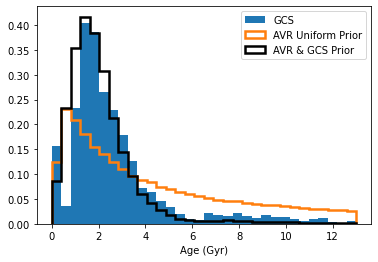

In [114]:
h=plt.hist(gcs_ages, density=True, label='GCS', bins=32, range=[0, 13])
h=plt.hist(trace['age'], density=True, histtype='step', lw=2.5,
           label='AVR Uniform Prior', bins=32, range=[0, 13])
#h=plt.hist(trace_metal['age'], density=True, histtype='step', lw=2.5, 
#           label='AVR GCS Prior', bins=32, range=[0, 13])
h=plt.hist(trace_custom['age'], density=True, histtype='step', lw=2.5, 
           label='AVR & GCS Prior ', bins=32, range=[0, 13], color='k')
plt.xlabel('Age (Gyr)')
plt.legend()

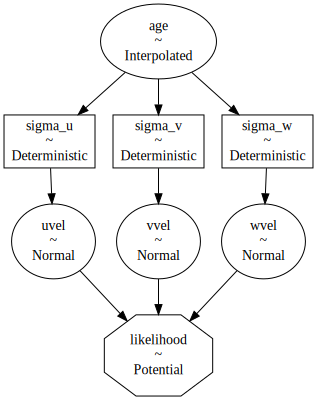

In [103]:
pm.model_to_graphviz(model_custom)

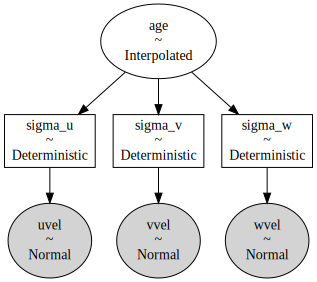

In [104]:
pm.model_to_graphviz(model_metal)

In [110]:
metal[0]-3*metal[-1], metal[0]+3*metal[-1]

(0.07999999999999996, 0.5)